In [107]:
import numpy as np
import pandas as pd
import csv
from scipy.spatial import distance
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

def read_dataset(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['label'].to_numpy()
    X = df.drop('label', axis=1).to_numpy()
    return X, y

cancer_data, cancer_labels = read_dataset('cancer.csv')
spam_data, spam_labels = read_dataset('spam.csv')

**KNN part**

In [108]:
def KNN_indices(data, new_data, k=10):
    distances = np.linalg.norm(data - new_data, axis=1)
    return np.argsort(distances)[:k]

def KNN(data, new_data, labels, K=10):
    indices = KNN_indices(data, new_data, K)
    nearest_labels = labels[indices]
    res = []
    for k in range(1, K + 1):
        counts = Counter(nearest_labels[:k]).most_common(1)[0]
        res.append(counts[0])
    return np.array(res)

def calculate_looerror(data, labels, K=10):
    errors = np.zeros(K, )
    for i in tqdm_notebook(range(len(data))):
        results = KNN(np.delete(data, i, axis=0), data[i], np.delete(labels, i))
        current_errors = results != labels[i]
        errors += current_errors
    errors /= data.shape[0]
    plt.plot(range(1, K + 1), errors)
    return errors

array([0.08435852, 0.08435852, 0.07381371, 0.07381371, 0.06678383,
       0.07029877, 0.0685413 , 0.0685413 , 0.06678383, 0.0685413 ])

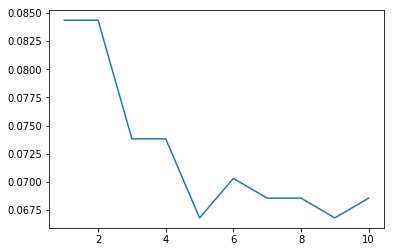

In [109]:
calculate_looerror(cancer_data, cancer_labels)

array([0.16931102, 0.16931102, 0.18561182, 0.17344056, 0.18582917,
       0.17670072, 0.19582699, 0.18235166, 0.20256466, 0.18713323])

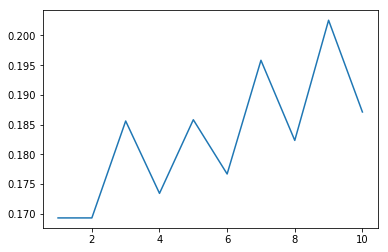

In [110]:
calculate_looerror(spam_data, spam_labels)

In [111]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(data):
    return MinMaxScaler().fit_transform(data)

array([0.08758965, 0.08758965, 0.09476201, 0.08911106, 0.0951967 ,
       0.08911106, 0.09932623, 0.09063247, 0.10193436, 0.09693545])

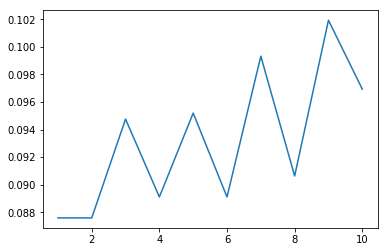

In [112]:
normalized_spam = normalize_data(spam_data.copy())
calculate_looerror(normalized_spam, spam_labels)

array([0.04745167, 0.04745167, 0.02987698, 0.02811951, 0.03339192,
       0.03163445, 0.02987698, 0.02987698, 0.02987698, 0.02636204])

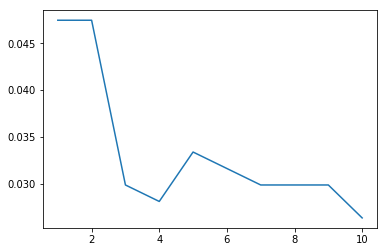

In [113]:
normalized_cancer = normalize_data(cancer_data.copy())
calculate_looerror(normalized_cancer, cancer_labels)

**Clustering part**

In [114]:
EPS = 1e-6

def kMean(data, k):
    centers = np.array([np.random.rand(data.shape[1]) for _ in range(k)])
    while True:
        ind = np.array([np.argmin(np.linalg.norm(centers - point, axis=1)) for point in data])
        # If it hapenned that there are 0 points for a cluster we will have problems. Let's fix it.
        if np.unique(ind).shape[0] != k:
            centers = np.array([np.random.rand(data.shape[1]) for _ in range(k)])
            continue
        new_centers = []
        for i in range(k):
            current_points = np.argwhere(ind == i).reshape(-1, )
            new_center = np.sum(data[current_points], axis=0) / len(current_points)
            new_centers.append(new_center)
        new_centers = np.array(new_centers)
        if np.linalg.norm(new_centers - centers) < EPS:
            return ind, centers
        centers = new_centers

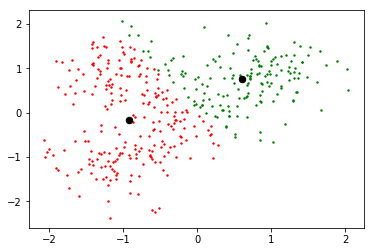

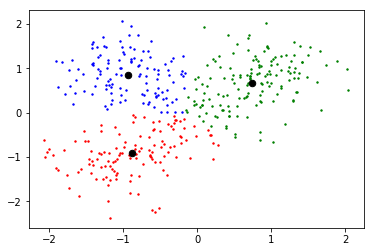

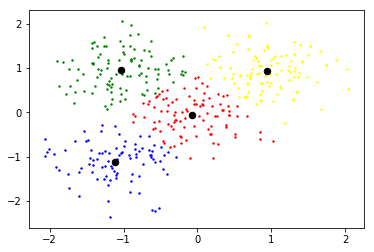

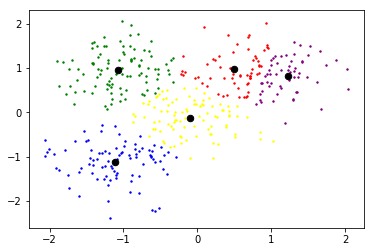

In [115]:
def read_blobs(path):
    df = pd.read_csv(path, skiprows=0)
    X = df.to_numpy()
    return X

blobs = read_blobs('blobs.csv')

def draw_clusters(clusters, centers=None):
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    plt.cla()
    for i, points in enumerate(clusters):
        plt.scatter(points[:, 0], points[:, 1], s=2, c=colors[i])
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], s=42, c='black')
    plt.show()

def do_kMean(data, max_k):
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    for k in range(2, max_k + 1):
        clusters, centers = kMean(data, k)
        draw_clusters([data[np.argwhere(clusters == i).reshape(-1, )] for i in range(k)], centers)

do_kMean(blobs, 5)

Found 2 clusters


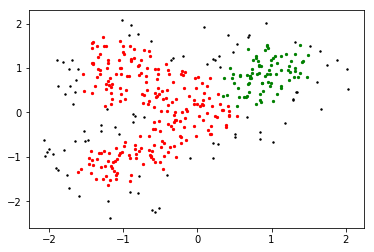

Found 3 clusters


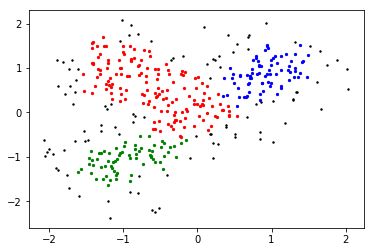

Found 4 clusters


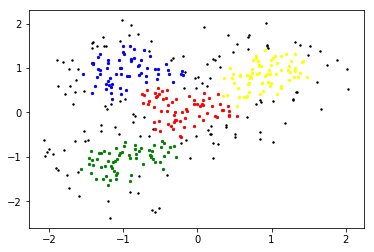

Found 5 clusters


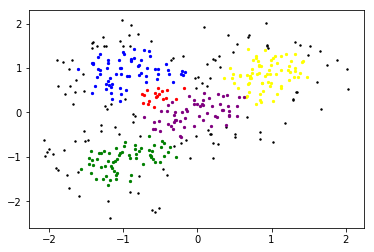

In [116]:
def dbscan(data, m, eps):
    centers = {}
    for i, row in enumerate(data):
        nearest = np.argwhere(np.linalg.norm(data - row, axis=1) <= eps).reshape(-1)
        if nearest.shape[0] > m:
            centers[i] = nearest
    
    labels = np.zeros(data.shape[0], )
    
    def dfs(point, cluster_index):
        if labels[point] != 0:
            return False
        labels[point] = cluster_index
        for nxt in centers.keys():
            if np.linalg.norm(data[point] - data[nxt]) <= eps:
                dfs(nxt, cluster_index)
        return True
    
    clusters = 0
    for center in centers:
        found = dfs(center, clusters + 1)
        if found:
            clusters += 1
            for center in np.argwhere(labels == clusters).reshape(-1):
                labels[centers[center]] = clusters
    return [data[np.argwhere(labels == i).reshape(-1)] for i in range(clusters + 1)]

def draw_dbscan_clusters(clusters):
    print('Found {} clusters'.format(len(clusters) - 1))
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    plt.cla()
    plt.scatter(clusters[0][:, 0], clusters[0][:, 1], s=2, c='black')
    for i, points in enumerate(clusters[1:]):
        plt.scatter(points[:, 0], points[:, 1], s=5, c=colors[i])
    plt.show()

draw_dbscan_clusters(dbscan(blobs, 6, 0.22))
draw_dbscan_clusters(dbscan(blobs, 7, 0.217))
draw_dbscan_clusters(dbscan(blobs, 8, 0.217))
draw_dbscan_clusters(dbscan(blobs, 10, 0.239))


Found 5 clusters


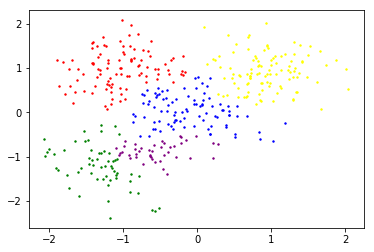

Found 4 clusters


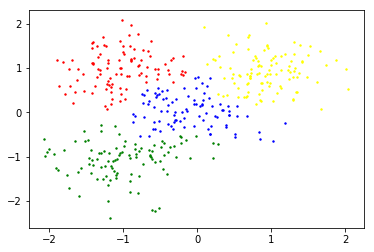

Found 3 clusters


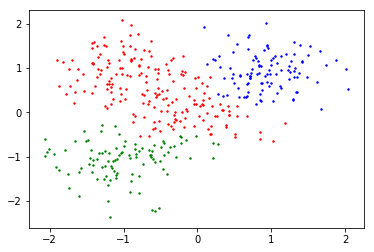

Found 2 clusters


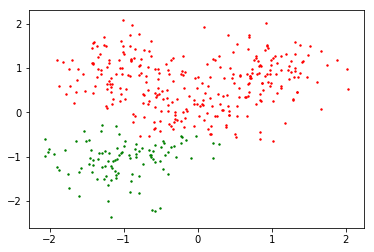

In [117]:
def algomerative_clustering(data, metric_fun, k=5):
    clusters = [[row] for row in data]
    results = []
    for _ in tqdm_notebook(range(data.shape[0] - 1)):
        best_value, best_pair = float('inf'), None
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                current_value = metric_fun(clusters[i], clusters[j])
                if current_value < best_value:
                    best_value = current_value
                    best_pair = (i, j)
        
        clusters[best_pair[0]].extend(clusters[best_pair[1]])
        clusters.pop(best_pair[1])
        best_value = float('inf')
        if len(clusters) <= k:
            results.append([np.array(cluster) for cluster in clusters])
    return results

def average_metric(x, y):
    z = np.concatenate([x, y])
    size = z.shape[0]
    return np.sum(distance.pdist(z) / (size * (size - 1) / 2))

clusters = algomerative_clustering(blobs, average_metric)
for clusterization in clusters[:-1]:
    print('Found {} clusters'.format(len(clusterization)))
    draw_clusters(clusterization)

In [118]:
def calc_purity(clusters, labels):
    max_cluster = np.max(clusters)
    value = 0
    for i in range(max_cluster + 1):
        cur_labels = labels[np.argwhere(clusters == i).reshape(-1)]
        value += Counter(cur_labels).most_common(1)[0][1]
    return value / len(clusters)

for k in [2, 3, 5, 10]:
    clusters, _ = kMean(normalized_cancer, k)
    print('Purity for {} clusters is {}'.format(k, calc_purity(clusters, cancer_labels)))

Purity for 2 clusters is 0.9279437609841827
Purity for 3 clusters is 0.9033391915641477
Purity for 5 clusters is 0.9033391915641477
Purity for 10 clusters is 0.9191564147627417


**Decision trees**

In [119]:
def find_roc_auc(feature, labels, eps):
    def calc_values(inverse_rool):
        tp_rate, fp_rate = [], []
        for threshold in np.arange(0, 1, eps):
            values = feature < threshold
            if inverse_rool:
                values = np.logical_not(values)
            tp_rate.append(np.sum(np.logical_and(values == labels, labels == 1)))
            fp_rate.append(np.sum(np.logical_and(values != labels, labels == 0)))
        tp_rate = np.array(tp_rate) / np.sum(labels == 1)
        fp_rate = np.array(fp_rate) / np.sum(labels == 0)
        return np.trapz(tp_rate, x=fp_rate), fp_rate, tp_rate
    
    auc1, x1, y1 = calc_values(False)
    auc2, x2, y2 = calc_values(True)
    if auc1 < abs(auc2):
        return abs(auc2), x2, y2
    return auc1, x1, y1

def draw_best_roc_curves(data, labels):
    aucs, curves = [], []
    for feature in tqdm_notebook(range(data.shape[1])):
        auc, x, y = find_roc_auc(data[:, feature], labels, 1e-4)
        aucs.append(auc)
        curves.append(np.stack((x, y), axis=-1))
    
    sorted_auc = np.argsort(np.array(aucs))
    curves = np.array(curves)
    for best in sorted_auc[-3:]:
        plt.plot(curves[best, :, 0], curves[best, :, 1])
        print(f'AUC for feature {best} is {aucs[best]}')


AUC for feature 54 is 0.7877744703682396
AUC for feature 55 is 0.8041625681254705
AUC for feature 51 is 0.8292095348356883


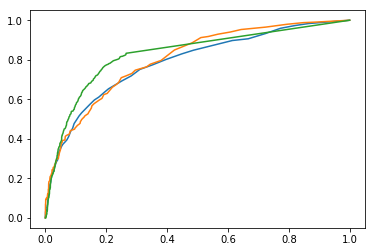

In [120]:
draw_best_roc_curves(normalized_spam, spam_labels)


AUC for feature 23 is 0.9698086781882566
AUC for feature 20 is 0.9704428941387876
AUC for feature 22 is 0.9754439511653719


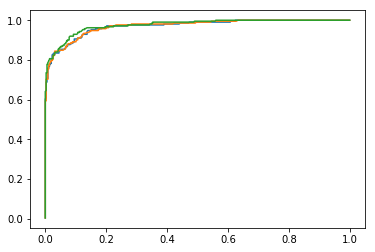

In [121]:
modified_cancer_labels = np.array([1 if l == 'M' else 0 for l in cancer_labels])
draw_best_roc_curves(normalized_cancer, modified_cancer_labels)

In [122]:
from sklearn.model_selection import train_test_split
def calc_proportions(labels):
    counter = Counter(labels)
    return counter[1] / (counter[1] + counter[0])

cancer_train, cancer_validation, cancer_train_labels, cancer_validation_labels = train_test_split(normalized_cancer, modified_cancer_labels, test_size=0.2)
spam_train, spam_validation, spam_train_labels, spam_validation_labels = train_test_split(normalized_spam, spam_labels, test_size=0.2)

print(f'Cancer train proportion {calc_proportions(cancer_train_labels)} \t Cancer validation proportion {calc_proportions(cancer_validation_labels)}')
print(f'Spam train proportion {calc_proportions(spam_train_labels)} \t Spam validation proportion {calc_proportions(spam_validation_labels)}')

Cancer train proportion 0.36923076923076925 	 Cancer validation proportion 0.38596491228070173
Spam train proportion 0.391304347826087 	 Spam validation proportion 0.40499457111834963


In [125]:
def calc_gini(labels):
    if not labels.shape[0]: return float('inf')
    counter = Counter(labels)
    return counter[1] * counter[0] / labels.shape[0] ** 2

class Node:
    feature = None
    threshold = None
    left, right = None, None
    answer = None
    
    def __init__(self, samples, labels, depth):
        self.samples = samples
        self.labels = labels
        self.size = labels.shape[0]
        self.depth = depth
        
    def __str__(self):
        return f'Threshold {self.threshold} for feature {self.feature}. Current size is {self.size}, depth is {self.depth}' 
    
    def split(self, max_depth=10):
        if self.depth == max_depth:
            self.answer = np.count_nonzero(np.logical_not(self.labels)) / self.size, np.count_nonzero(self.labels) / self.size
            return
        
        max_gain = 0
        best_feature = None
        best_threshold = None
        left, right = None, None
        
        for f in range(self.samples.shape[1]):
            cur_f = self.samples[:, f]
            for threshold in np.unique(cur_f):
                hypothesis = cur_f <= threshold
                labels1 = self.labels[hypothesis]
                labels2 = self.labels[np.logical_not(hypothesis)]
                cur_gini = calc_gini(self.labels)
                
                inf_gain = self.size * cur_gini - labels1.shape[0] * calc_gini(labels1) - labels2.shape[0] * calc_gini(labels2)
                if inf_gain > max_gain and labels1.shape[0] and labels2.shape[0]:
                    
                    max_gain = inf_gain
                    best_feature = f
                    best_threshold = threshold
                    left, right = hypothesis, np.logical_not(hypothesis)
        if best_feature is None:
            self.answer = np.count_nonzero(np.logical_not(self.labels)) / self.size, np.count_nonzero(self.labels) / self.size
            return
        
        left = Node(self.samples[left], self.labels[left], self.depth + 1)
        right = Node(self.samples[right], self.labels[right], self.depth + 1)
        self.feature = best_feature
        self.threshold = best_threshold
        self.left, self.right = left, right
        left.split(max_depth)
        right.split(max_depth)
        
def build_tree(data, labels, max_depth=10):
    root = Node(data, labels, 0)
    root.split(max_depth)
    return root
    
def find_class(probs):
    return 0 if np.random.uniform() < probs[0] else 1

def find_probabilites(point, root):
    cur_node = root
    while cur_node.answer == None:
        if point[cur_node.feature] <= cur_node.threshold:
            cur_node = cur_node.left
        else:
            cur_node = cur_node.right
    return np.array(cur_node.answer)
    
def find_accuracy(data, labels, tree):
    correct = 0
    for pt, label in zip(data, labels):
        if find_class(find_probabilites(pt, tree)) == label:
            correct += 1
    return correct / data.shape[0]

def print_accuracies_for_depth(train_data, train_labels, val_data, val_labels):
    for d in range(1, 10):
        tree = build_tree(train_data, train_labels, d)
        acc = find_accuracy(val_data, val_labels, tree)
        print(f'Accuracy for depth {d} is {acc}')

In [126]:
print_accuracies_for_depth(cancer_train, cancer_train_labels, cancer_validation,cancer_validation_labels)

Accuracy for depth 1 is 0.8070175438596491
Accuracy for depth 2 is 0.868421052631579
Accuracy for depth 3 is 0.9122807017543859
Accuracy for depth 4 is 0.9385964912280702
Accuracy for depth 5 is 0.9473684210526315
Accuracy for depth 6 is 0.9473684210526315
Accuracy for depth 7 is 0.9473684210526315
Accuracy for depth 8 is 0.9473684210526315
Accuracy for depth 9 is 0.9473684210526315


In [127]:
print_accuracies_for_depth(spam_data, spam_labels, spam_validation, spam_validation_labels)

Accuracy for depth 1 is 0.5874049945711184
Accuracy for depth 2 is 0.6666666666666666
Accuracy for depth 3 is 0.7046688382193268
Accuracy for depth 4 is 0.6905537459283387
Accuracy for depth 5 is 0.7024972855591748
Accuracy for depth 6 is 0.7068403908794788
Accuracy for depth 7 is 0.7090119435396308
Accuracy for depth 8 is 0.7220412595005429
Accuracy for depth 9 is 0.7100977198697068


In [128]:
from sklearn.metrics import roc_curve

def draw_rocs_for_prob_thresholds(X_train, y_train, X_val, y_val, depth):
    tree = build_tree(X_train, y_train, depth)
    probs = np.array([find_probabilites(pt, tree) for pt in X_val])
    frp, tpr, _ = roc_curve(y_val, probs[:, 0])
    plt.plot(tpr.tolist(), frp.tolist())

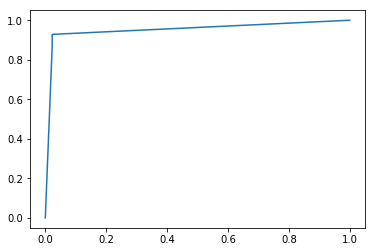

In [129]:
draw_rocs_for_prob_thresholds(cancer_train, cancer_train_labels, cancer_validation, cancer_validation_labels, depth=5)

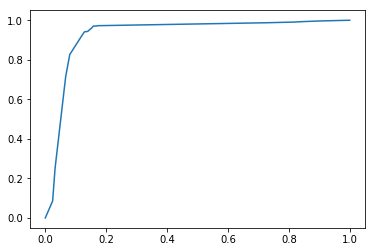

In [130]:
draw_rocs_for_prob_thresholds(spam_train, spam_train_labels, spam_validation, spam_validation_labels, depth=8)